In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
data = pd.read_csv('balance_scale.csv')
data.columns = data.columns.str.strip()
data.head()

,Class,Left-Weight,Left-Distance,Right-Weight,Right-Distance
0,B,1,1,1,1
1,R,1,1,1,2
2,R,1,1,1,3
3,R,1,1,1,4
4,R,1,1,1,5


In [4]:
datasets = data.copy()
print(datasets)
cols_to_encode = ['Class']
le = LabelEncoder()
for col in cols_to_encode:
    datasets[col] = le.fit_transform(datasets[col].str.strip())  # Strip spaces before encoding

datasets.head()

    Class  Left-Weight  Left-Distance  Right-Weight  Right-Distance
0       B            1              1             1               1
1       R            1              1             1               2
2       R            1              1             1               3
3       R            1              1             1               4
4       R            1              1             1               5
..    ...          ...            ...           ...             ...
620     L            5              5             5               1
621     L            5              5             5               2
622     L            5              5             5               3
623     L            5              5             5               4
624     B            5              5             5               5

[625 rows x 5 columns]


,Class,Left-Weight,Left-Distance,Right-Weight,Right-Distance
0,0,1,1,1,1
1,2,1,1,1,2
2,2,1,1,1,3
3,2,1,1,1,4
4,2,1,1,1,5


In [5]:
data_true= datasets.copy()

In [6]:
# Simulate missing values in the target (MAR assumption)
np.random.seed(42)
missing_rate = 0.1  # 10% missing
missing_indices = datasets.sample(frac=missing_rate).index
datasets.loc[missing_indices, 'Class'] = np.nan
datasets

,Class,Left-Weight,Left-Distance,Right-Weight,Right-Distance
0,0.0,1,1,1,1
1,2.0,1,1,1,2
2,NaN,1,1,1,3
3,2.0,1,1,1,4
4,2.0,1,1,1,5
...,...,...,...,...,...
620,NaN,5,5,5,1
621,NaN,5,5,5,2
622,1.0,5,5,5,3
623,1.0,5,5,5,4


In [7]:
# Separate features and target
features = datasets.drop(columns=['Class'])
target = datasets['Class']

In [8]:
#print(datasets.isnull().sum())
missing_indices = datasets[datasets['Class'].isna()].index
y_TEST = data_true.loc[missing_indices, 'Class']
print(y_TEST)

2      2
10     2
30     0
31     2
39     2
      ..
600    1
608    1
612    1
620    1
621    1
Name: Class, Length: 62, dtype: int64


In [9]:
missing_data = datasets[datasets['Class'].isna()]
missing_data

,Class,Left-Weight,Left-Distance,Right-Weight,Right-Distance
2,NaN,1,1,1,3
10,NaN,1,1,3,1
30,NaN,1,2,2,1
31,NaN,1,2,2,2
39,NaN,1,2,3,5
...,...,...,...,...,...
600,NaN,5,5,1,1
608,NaN,5,5,2,4
612,NaN,5,5,3,3
620,NaN,5,5,5,1


In [10]:
non_missing_data = datasets[datasets['Class'].notna()]
non_missing_data

,Class,Left-Weight,Left-Distance,Right-Weight,Right-Distance
0,0.0,1,1,1,1
1,2.0,1,1,1,2
3,2.0,1,1,1,4
4,2.0,1,1,1,5
5,2.0,1,1,2,1
...,...,...,...,...,...
618,1.0,5,5,4,4
619,1.0,5,5,4,5
622,1.0,5,5,5,3
623,1.0,5,5,5,4


In [11]:
cols = [col for col in datasets.columns if col !='Class'] + ['Class']
missing_data = missing_data[cols]
non_missing_data = non_missing_data[cols]

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [13]:
X_complete = non_missing_data.drop(columns=['Class'])
y_complete = non_missing_data['Class']
X_missing = missing_data.drop(columns=['Class'])

# 1. Mean/Median Imputation

In [14]:
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')

**# Fit on complete data and transform missing data**

In [15]:
mean_imputed = mean_imputer.fit_transform(y_complete.values.reshape(-1, 1))
median_imputed = median_imputer.fit_transform(y_complete.values.reshape(-1, 1))

**filling missing value in the missing_data 'Class'**

In [16]:
missing_data_mean = missing_data.copy()
missing_data_mean['Class'] = mean_imputer.transform(missing_data_mean['Class'].values.reshape(-1, 1))

In [17]:
missing_data_median = missing_data.copy()
missing_data_median['Class'] = median_imputer.transform(missing_data_median['Class'].values.reshape(-1, 1))

In [18]:
datasets_mean_filled = pd.concat([non_missing_data, missing_data_mean]).sort_index()
datasets_median_filled = pd.concat([non_missing_data, missing_data_median]).sort_index()

**now compare with the original cibil score**

In [19]:
# Imputed 'Class' values for missing rows
mean_pred = mean_imputer.transform(missing_data['Class'].values.reshape(-1, 1))
median_pred = median_imputer.transform(missing_data['Class'].values.reshape(-1, 1))

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Flatten predicted values
mean_pred_flat = mean_pred.flatten()
median_pred_flat = median_pred.flatten()
y_true = y_TEST.values

# Mean Imputation Errors
mae_mean = mean_absolute_error(y_true, mean_pred_flat)
rmse_mean = np.sqrt(mean_squared_error(y_true, mean_pred_flat))

# Median Imputation Errors
mae_median = mean_absolute_error(y_true, median_pred_flat)
rmse_median = np.sqrt(mean_squared_error(y_true, median_pred_flat))

# Display results
print("📊 Mean Imputation:")
print(f"MAE: {mae_mean:.2f}, \nRMSE: {rmse_mean:.2f}")

print("\n📊 Median Imputation:")
print(f"MAE: {mae_median:.2f}, \nRMSE: {rmse_median:.2f}")


📊 Mean Imputation:
MAE: 0.60, 
RMSE: 0.67

📊 Median Imputation:
MAE: 0.53, 
RMSE: 0.73


# 2. K-NN Imputation

In [21]:
knn_imputer = KNNImputer(n_neighbors=5)
# Combine features and target for k-NN imputation
knn_data = pd.concat([X_complete, y_complete], axis=1)
knn_imputed = knn_imputer.fit_transform(knn_data)
knn_imputed_scores = knn_imputed[-len(X_missing):, -1]

**filling missing value in datasets**

In [22]:
from sklearn.impute import KNNImputer

# Combine features and target (including missing Class values!)
knn_input = datasets.copy()

# Apply KNN Imputer on full data
knn_imputer = KNNImputer(n_neighbors=5)
imputed_array = knn_imputer.fit_transform(knn_input)

# Create imputed DataFrame
imputed_datasets = pd.DataFrame(imputed_array, columns=datasets.columns, index=datasets.index)

# Extract only the imputed Class for missing rows
datasets.loc[missing_indices, 'Class'] = imputed_datasets.loc[missing_indices, 'Class']

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = datasets.loc[missing_indices, 'Class']
y_true = y_TEST  # original values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("📊 KNN Imputation Evaluation:")
print(f"✅ MAE : {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")

📊 KNN Imputation Evaluation:
✅ MAE : 0.39
✅ RMSE: 0.65


# 3. MICE Imputation

In [24]:
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Define MICE Imputer with a stronger estimator
mice_imputer = IterativeImputer(
    estimator=GradientBoostingRegressor(n_estimators=100, random_state=42),
    max_iter=10,
    random_state=42
)

# 2. Combine features + target
mice_data = pd.concat([X_complete, y_complete], axis=1)

# 3. Fit-transform the complete data
mice_imputed = mice_imputer.fit_transform(mice_data)

# 4. Convert back to DataFrame for easy access
mice_imputed_df = pd.DataFrame(mice_imputed, columns=mice_data.columns, index=mice_data.index)

# 5. Train imputer again on full data (optional) and transform missing part
full_data = pd.concat([X_complete, X_missing])
mice_imputer.fit(mice_data)
missing_data_mice = pd.concat([X_missing, pd.Series([np.nan]*len(X_missing), name='Class', index= X_missing.index)], axis=1)
mice_imputed_missing = mice_imputer.transform(missing_data_mice)
mice_imputed_scores = mice_imputed_missing[:, -1]



In [25]:
# 6. Evaluate against ground truth
mae_mice = mean_absolute_error(y_TEST, mice_imputed_scores)
rmse_mice = np.sqrt(mean_squared_error(y_TEST, mice_imputed_scores))

print("📊 MICE Imputation Evaluation (with GradientBoostingRegressor):")
print(f"✅ MAE : {mae_mice:.2f}")
print(f"✅ RMSE: {rmse_mice:.2f}")

📊 MICE Imputation Evaluation (with GradientBoostingRegressor):
✅ MAE : 0.44
✅ RMSE: 0.61


# 4. Random Forest Imputation

**prepare data**

In [26]:
# Features (X) and target (y) from non-missing data
X = non_missing_data.drop(columns=['Class'])
y = non_missing_data['Class']

# Features for missing data (to be imputed)
X_missing = missing_data.drop(columns=['Class'])

# True values for missing data (y_TEST)
y_true = y_TEST  # Ensure shapes match!

**Split non_missing_data into Train/Validation Sets**

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Train the Model**

In [28]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

**Evaluate on Validation Set**

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_val_pred = model.predict(X_val)
# Calculate MAE and MSE
mae_val = mean_absolute_error(y_val, y_val_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

# Manually calculate RMSE from MSE
rmse_val = np.sqrt(mse_val)

print(f"✅Validation MAE: {mae_val:.2f}")
print(f"✅Validation RMSE: {rmse_val:.2f}")

✅Validation MAE: 0.24
✅Validation RMSE: 0.47


**Predict Missing Values & Compare with y_TEST**

In [30]:
y_missing_pred = model.predict(X_missing)

# Calculate metrics for missing data predictions
mae_missing = mean_absolute_error(y_true, y_missing_pred)
mse_missing = mean_squared_error(y_true, y_missing_pred)
rmse_missing = np.sqrt(mse_missing)

print(f"\n✅Imputation MAE (vs y_TEST): {mae_missing:.2f}")
print(f"✅Imputation RMSE (vs y_TEST): {rmse_missing:.2f}")



✅Imputation MAE (vs y_TEST): 0.40
✅Imputation RMSE (vs y_TEST): 0.63


🔍 Imputation Results Summary:
               Mean  Median       k-NN       MICE  Random Forest
count  6.200000e+01    62.0  62.000000  62.000000      62.000000
mean   1.390764e+00     1.0   0.983871   1.280656       1.259516
std    6.715717e-16     0.0   0.383766   0.399297       0.450054
min    1.390764e+00     1.0   0.000000   0.342552       0.480000
25%    1.390764e+00     1.0   1.000000   0.973998       0.972500
50%    1.390764e+00     1.0   1.000000   1.314208       1.115000
75%    1.390764e+00     1.0   1.000000   1.456509       1.640000
max    1.390764e+00     1.0   2.000000   2.250328       2.000000


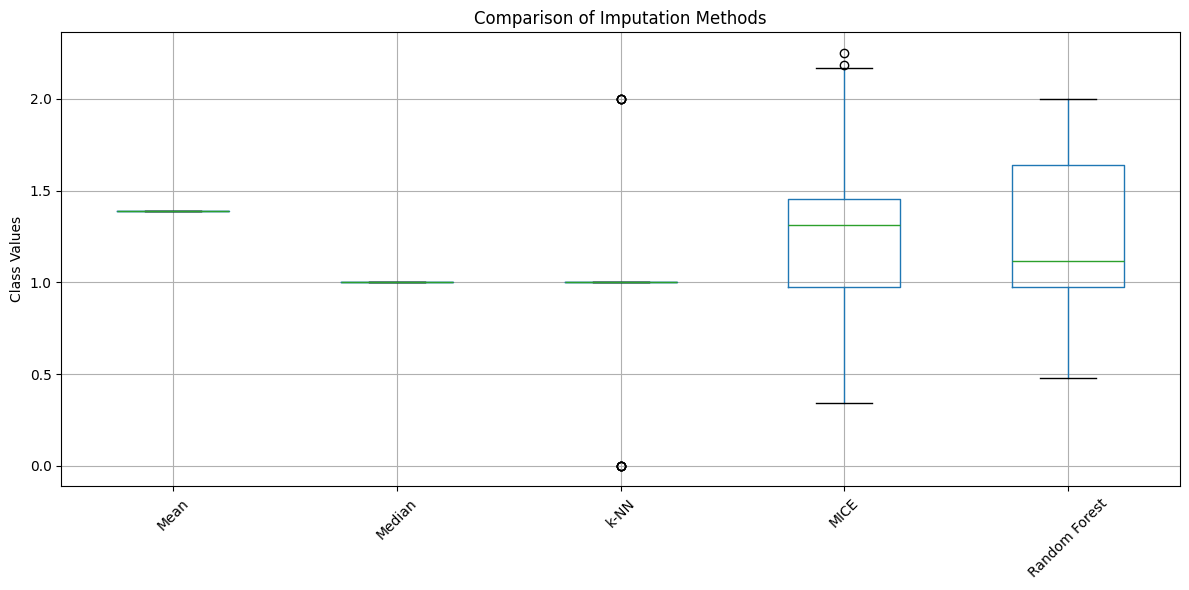

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a results DataFrame comparing all methods
results = pd.DataFrame({
    'Mean': mean_pred[:len(X_missing)].flatten(),
    'Median': median_pred[:len(X_missing)].flatten(),
    'k-NN': knn_imputed_scores,
    'MICE': mice_imputed_scores,
    'Random Forest': y_missing_pred 
    
})

# Summary statistics
print("🔍 Imputation Results Summary:")
print(results.describe())

# Visualization using box plot
plt.figure(figsize=(12, 6))
results.boxplot()
plt.title("Comparison of Imputation Methods")
plt.ylabel("Class Values")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


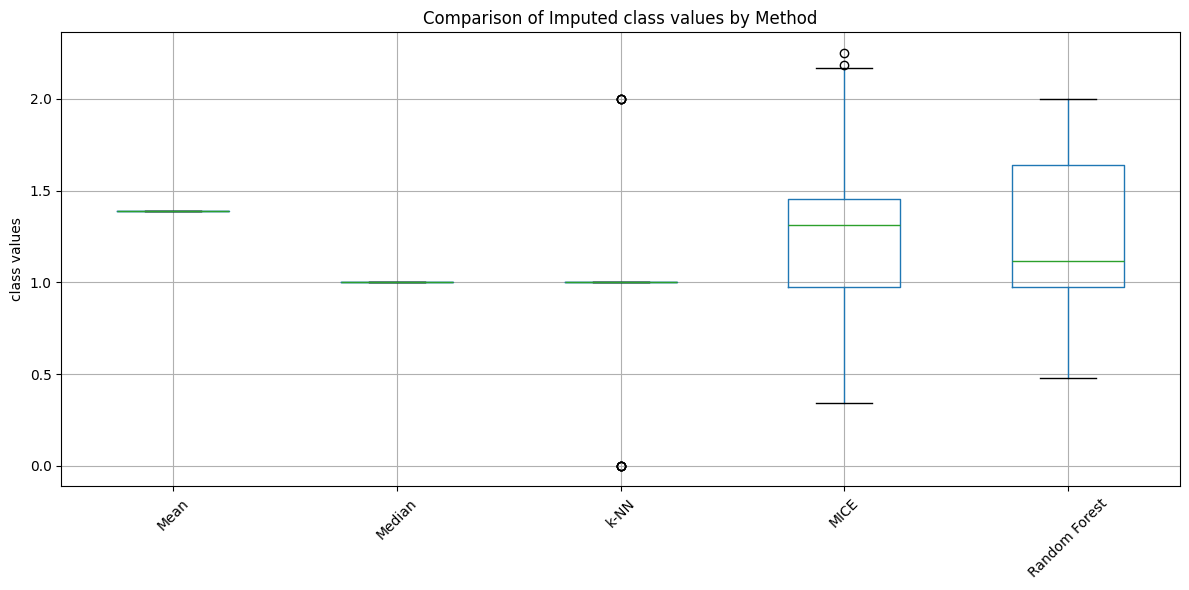

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot for imputed values
plt.figure(figsize=(12, 6))
results.boxplot()
plt.title('Comparison of Imputed class values by Method')
plt.ylabel('class values')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_13836\3425954819.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_13836\3425954819.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


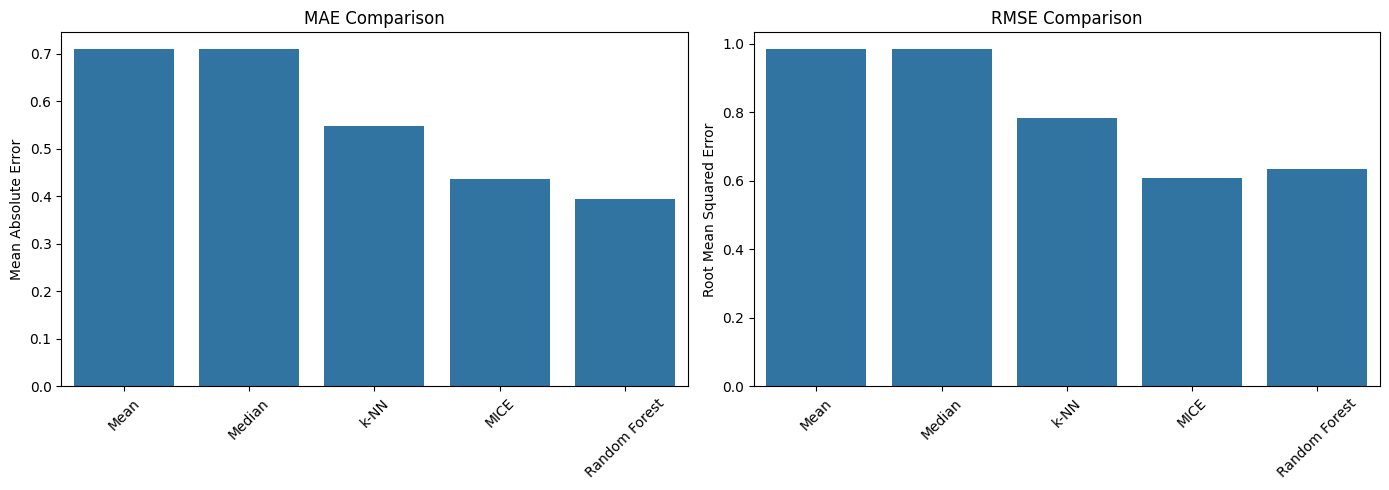

In [33]:
# Define MAE and RMSE values for each model
mae_scores = {
    'Mean': mean_absolute_error(y_TEST, mean_imputed[:len(y_TEST)].flatten()),
    'Median': mean_absolute_error(y_TEST, median_imputed[:len(y_TEST)].flatten()),
    'k-NN': mean_absolute_error(y_TEST, knn_imputed_scores),
    'MICE': mean_absolute_error(y_TEST, mice_imputed_scores),
    'Random Forest': mean_absolute_error(y_TEST, y_missing_pred),
    
}

rmse_scores = {
    'Mean': np.sqrt(mean_squared_error(y_TEST, mean_imputed[:len(y_TEST)].flatten())),
    'Median': np.sqrt(mean_squared_error(y_TEST, median_imputed[:len(y_TEST)].flatten())),
    'k-NN': np.sqrt(mean_squared_error(y_TEST, knn_imputed_scores)),
    'MICE': np.sqrt(mean_squared_error(y_TEST, mice_imputed_scores)),
    'Random Forest': np.sqrt(mean_squared_error(y_TEST, y_missing_pred)),
    
}

# Bar plots for MAE and RMSE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=list(mae_scores.keys()), y=list(mae_scores.values()), ax=axes[0])
axes[0].set_title('MAE Comparison')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.barplot(x=list(rmse_scores.keys()), y=list(rmse_scores.values()), ax=axes[1])
axes[1].set_title('RMSE Comparison')
axes[1].set_ylabel('Root Mean Squared Error')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()
